In [1]:
# import library
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import time
import yaml
import sys
import os
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasetgenerator.DatasetGenerator import DatasetGenerator

In [2]:
# make function
def makedir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def print_and_file_write(file, string):
    file.write(string + "\n")
    print(string)

In [3]:
# open congig yaml file.
print("open config file...")
with open("config.yaml") as file:
    print("complete!")
    yml = yaml.safe_load(file)

open config file...
complete!


In [4]:
# Dataset Generator loadding.
dataset = DatasetGenerator()
print("test dataset loading...")
print("--------- dataset ---------")
if yml["testresourcedata"]["readdata"] == "text" or yml["testresourcedata"]["readdata"] == "TEXT":
    input, answer = dataset.text_dataset(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.text_datacounter(yml["testresourcedata"]["resourcepath"])
elif yml["testresourcedata"]["readdata"] == "onefolder" or yml["testresourcedata"]["readdata"] == "Onefolder":
    input, answer = dataset.onefolder_dataet(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.onefolder_datacounter(yml["testresourcedata"]["resourcepath"])
elif yml["testresourcedata"]["readdata"] == "folder" or yml["testresourcedata"]["readdata"] == "Folder":
    input, answer = dataset.folder_dataset(yml["testresourcedata"]["resourcepath"])
    datacount = dataset.folder_datacounter(yml["testresourcedata"]["resourcepath"])
else:
    print("It appears that you have selected a data loader that is not specified. Stops the program.")
    exit(1)
print("test data : ", datacount)
print("---------------------------")
print("---------- class ----------")
classes = yml["Resourcedata"]["classes"]
for c in classes:
    print(c)
print("---------------------------")

test dataset loading...
--------- dataset ---------
test data :  810
---------------------------
---------- class ----------
choki
goo
paa
---------------------------


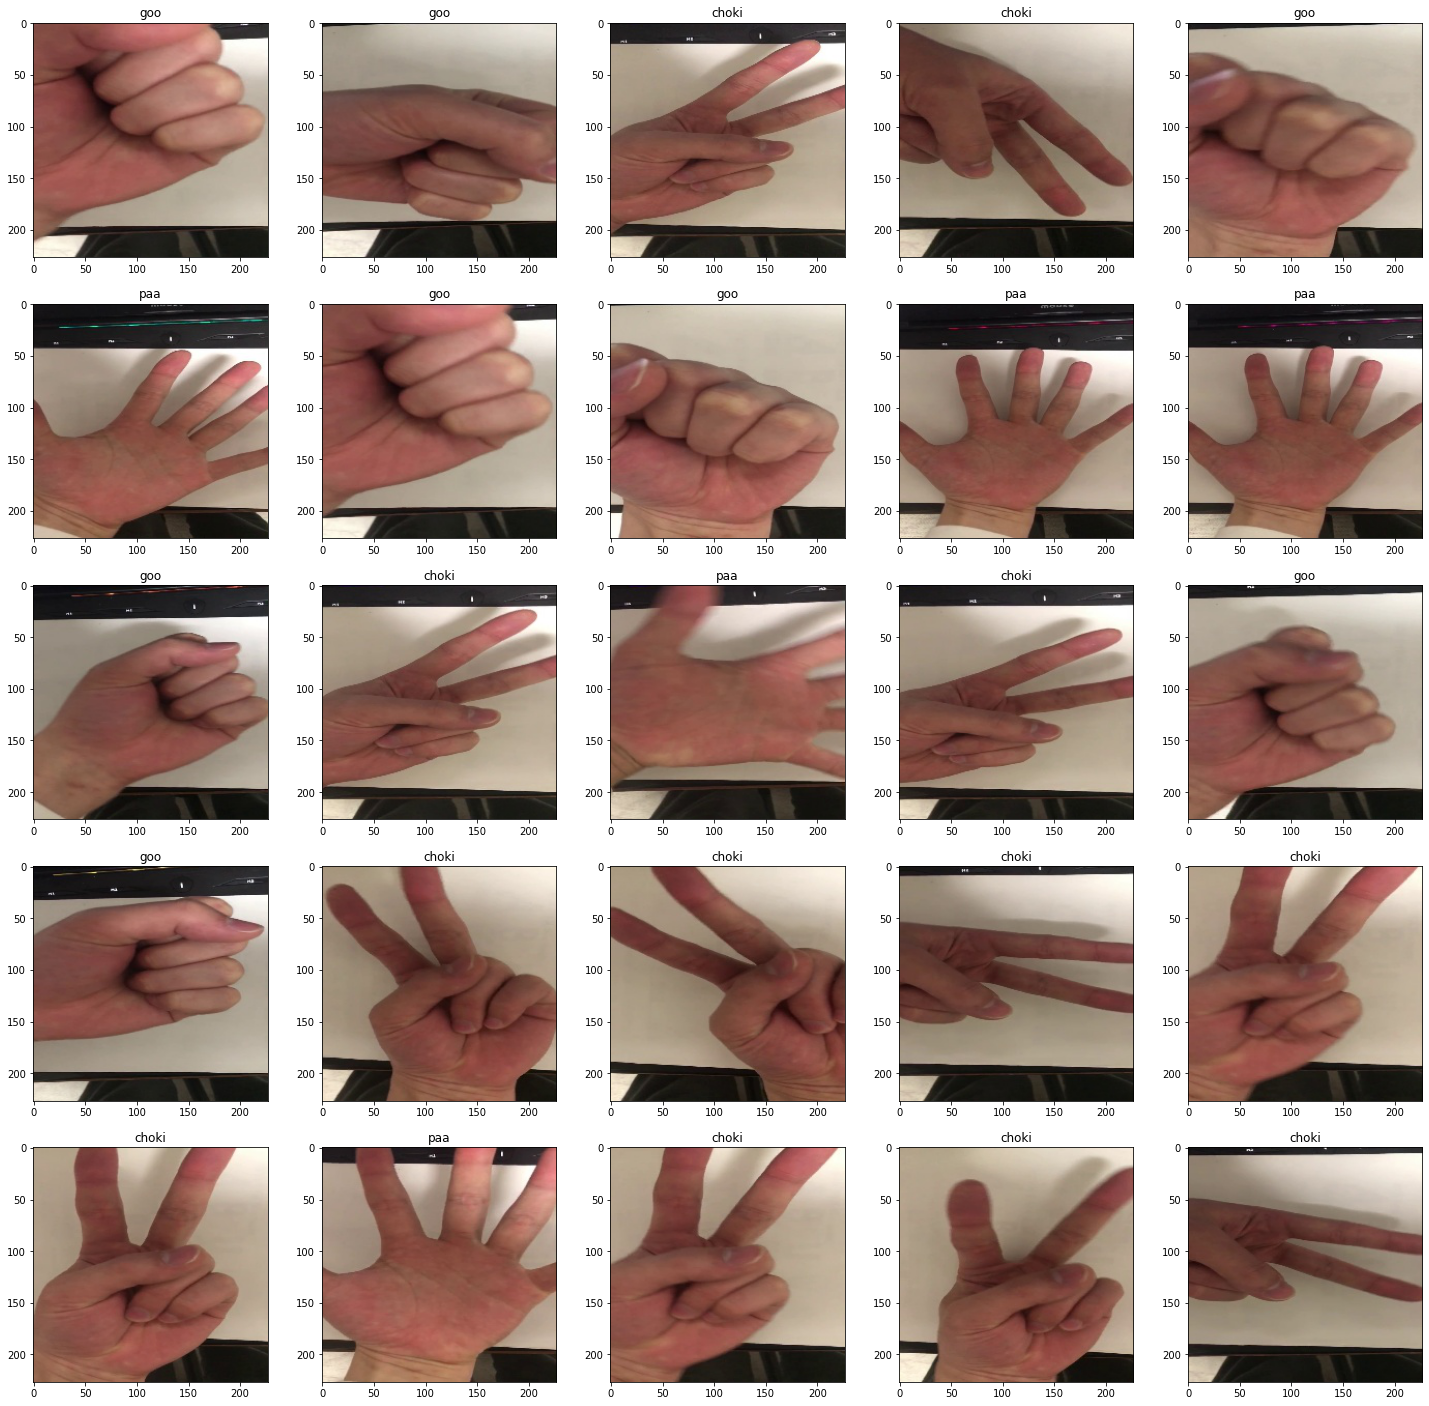

In [5]:
# plot dataset
xdata, ydata = [], []

# load dataset... and read PIL image.
for x in range(25):
    rand_num=np.random.randint(0,datacount)
    xdata.append(img_to_array(load_img(input[rand_num], color_mode="rgb", target_size=(yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"])))/255)
    ydata.append(answer[rand_num])

# image plot
plt.figure(figsize=(25,25), facecolor='white')
for i in range(25):
    cifar_img=plt.subplot(5,5,i+1)
    plt.imshow(xdata[i])
    plt.tick_params(labelbottom='off')
    plt.tick_params(labelleft='off')
    plt.title(classes[int(ydata[i])])
# show img
plt.show()

In [6]:
print("---------  model  ---------")
# open congig yaml file.
model = load_model(yml["TESTModel"]["path"] + yml["TESTModel"]["weight_path"])
print("Load model weight...")
model.load_weights(yml["TESTModel"]["path"] + yml["TESTModel"]["weight_path"])
model.summary()
print("---------------------------")

---------  model  ---------
Load model weight...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               20971776  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 23,230,531
Trainable params: 22,343,107
Non-trainable params: 887,424
_________________________________________________________________
---------------------------


In [7]:
predict_list, ans_list, predict_rawdata = [], [], []

for count, (x, ans) in enumerate(zip(input, answer)):
    # image file open.
    try:
        # I'll load the image, and if it doesn't work, I'll terminate the program.
        image = img_to_array(load_img(x, color_mode="rgb", target_size=(yml["testresourcedata"]["img_row"], yml["testresourcedata"]["img_col"])))
        # Normalize image.
        image /= 255.
    except Exception as e:
        print("Failed to load data.")
        print("ERROR : ", e)
        exit(1)

    # model predict => pred_label
    predict = model.predict(np.asarray([image], np.float32), batch_size=1)
    predict_rawdata.append(predict)
    
    predict_list.append(np.argmax(predict))
    # ans => answer list
    ans_list.append(int(ans))

    # Raw data of predicted values
    #print(predict)

In [8]:
# calassification report. and write csv

result = classification_report(ans_list, predict_list, target_names = classes, output_dict=True)
print("--------------< result >--------------")
print(classification_report(ans_list, predict_list, target_names = yml["Resourcedata"]["classes"]))
print("--------------------------------------")
class_pd = pd.DataFrame(result)
class_pd.to_csv(yml["TESTModel"]["path"] + "/classification_report.csv")

--------------< result >--------------
              precision    recall  f1-score   support

       choki       0.54      1.00      0.70       300
         goo       1.00      0.94      0.97       270
         paa       1.00      0.01      0.02       240

    accuracy                           0.69       810
   macro avg       0.85      0.65      0.56       810
weighted avg       0.83      0.69      0.59       810

--------------------------------------


In [9]:
# correct list and uncorrect list creat.
print("correct and fail predict list create...")

correct_list, uncorrect_list = [], []
for (image_path, prd, ans, raw_prd) in zip(input, predict_list, ans_list, predict_rawdata):
    if ans == prd:
        correct_list.append([image_path, ans, prd, str(raw_prd.tolist())])
    else:
        uncorrect_list.append([image_path, ans, prd, str(raw_prd.tolist())])
correct_df = pd.DataFrame(correct_list, columns=['inputdata', 'answer', 'predict', 'predict_rawdata'],index=range(len(correct_list)))
uncorrect_df = pd.DataFrame(uncorrect_list, columns=['inputdata', 'answer', 'predict', 'predict_rawdata'],index=range(len(uncorrect_list)))

#print(correct_df)
#print(uncorrect_df)

print("result write csv...")
correct_df.to_csv(yml["TESTModel"]["path"] + "/predict_correct_list.csv")
uncorrect_df.to_csv(yml["TESTModel"]["path"] + "/predict_uncorrect_list.csv")
print("complate")

correct and fail predict list create...
result write csv...
complate


In [10]:
# show detail result. 
# Indicate which items are being answered and by how much.
category_result = [0] * len(classes)
class_count = 0

# for result write file.
with open(yml["TESTModel"]["path"] + "/predict_result.txt", mode='w') as f:
    print_and_file_write(f, "data count : {}".format(datacount))

    for category in range(len(classes)):
        print_and_file_write(f, "============{}================".format(classes[category]))
        # Check your predict and answers.
        for (prd, ans) in zip(predict_list, ans_list):
            # If the answer and the category (rotating in a for loop) match, add the number of categories inferred
            if category == ans:
                category_result[prd] += 1
                class_count += 1
        # Show the results of the inference.
        for c, prd_count in enumerate(category_result):
            print_and_file_write(f ,"answer = {}, predict {} => {}".format(classes[category], classes[c], prd_count))
        # Show the number of each category
        print_and_file_write(f, "class data count : {}".format(class_count))
        # reset result list. and reset class count
        category_result = [0] * len(classes)
        class_count = 0 
    print_and_file_write(f, "=====================================")

data count : 810
============choki================
answer = choki, predict choki => 300
answer = choki, predict goo => 0
answer = choki, predict paa => 0
class data count : 300
============goo================
answer = goo, predict choki => 15
answer = goo, predict goo => 255
answer = goo, predict paa => 0
class data count : 270
============paa================
answer = paa, predict choki => 237
answer = paa, predict goo => 1
answer = paa, predict paa => 2
class data count : 240


In [11]:
# show detail result. 
# Indicate which items are being answered and by how much.
category_result = [0] * len(classes)
class_count = 0

predict_index = "choki"
answer_index = "goo"
filename = "/filterresult.txt"

# Examine the index of a given category
predict_index = [i for i, cate in enumerate(classes) if cate == predict_index]
answer_index = [i for i, cate in enumerate(classes) if cate == answer_index]

# for result write file.
with open(yml["TESTModel"]["path"] + filename, mode='w') as f:
    # Check your predict and answers.
    for (img, prd, ans) in zip(input, predict_list, ans_list):
        # If the answer and the category (rotating in a for loop) match, add the number of categories inferred
        if ans == answer_index[0] and prd == predict_index[0]:
            print_and_file_write(f, img)

./dataset\goo\goo_173.jpg
./dataset\goo\goo_174.jpg
./dataset\goo\goo_175.jpg
./dataset\goo\goo_176.jpg
./dataset\goo\goo_177.jpg
./dataset\goo\goo_178.jpg
./dataset\goo\goo_179.jpg
./dataset\goo\goo_180.jpg
./dataset\goo\goo_181.jpg
./dataset\goo\goo_182.jpg
./dataset\goo\goo_183.jpg
./dataset\goo\goo_184.jpg
./dataset\goo\goo_185.jpg
./dataset\goo\goo_186.jpg
./dataset\goo\goo_188.jpg
